In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import rpy2.robjects as robjects
import matplotlib
# INSTALL R VERSION 3.5.3

matplotlib.rcParams.update({'font.size': 14})

In [2]:
plt.rcParams["figure.figsize"] = (10, 5)
PATH_TO_IMG = "../Tesina/img"
YLIM = (125, 140)

### Leer los datos

In [3]:
df = pd.read_csv("../Datos/tesis_final_preprocesado.csv")
df_basal = df[df["Mes"] == 1]

### Análisis de datos de interés

In [4]:
prop_hombres = df_basal["Sexo"].mean()
edad_media = df_basal["Edad"].mean()
desvio_edad = df_basal["Edad"].std()
edad_min = df_basal["Edad"].min()
edad_max = df_basal["Edad"].max()
tas_media = df_basal["TAS"].mean()
tas_desvio = df_basal["TAS"].std()

### Análisis de la respuesta

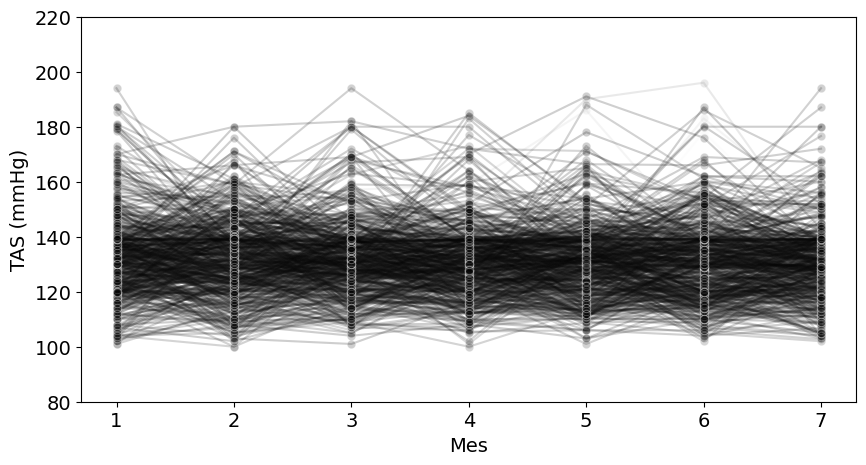

In [5]:
lineplot = sns.lineplot(
    x=df["Mes"],
    y=df["TAS"],
    hue=df["idPaciente"],
    marker="o",
    palette="Greys",
    alpha=0.2
)
plt.ylabel("TAS (mmHg)")
lineplot.get_legend().remove()
plt.ylim((80, 220))
plt.savefig(
    f"{PATH_TO_IMG}/TAS_vs_tpo_perfiles_individuales.png",
    bbox_inches='tight'
)

C:\Users\esteb\AppData\Local\Temp\ipykernel_12888\1497621338.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


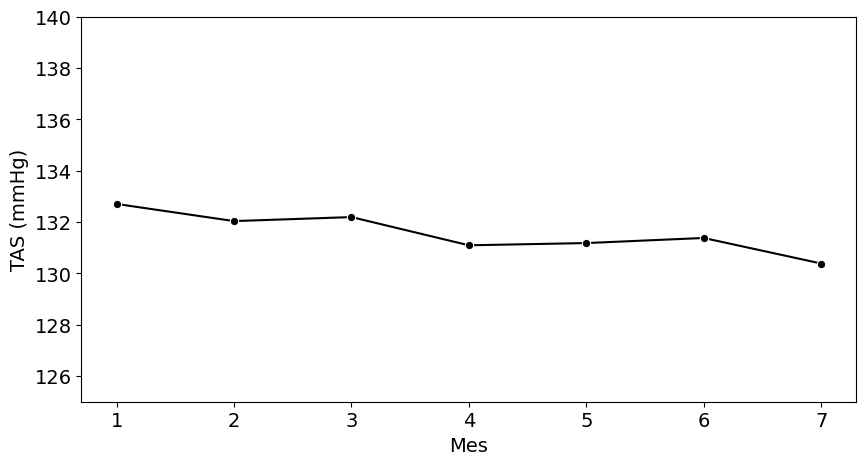

In [6]:
sns.lineplot(
    x=df["Mes"],
    y=df["TAS"],
    marker="o",
    color="black",
    ci=None
)
plt.ylim(YLIM)
plt.ylabel("TAS (mmHg)")
plt.savefig(f"{PATH_TO_IMG}/TAS_vs_tpo.png", bbox_inches='tight')

### Análisis bivariado a través del tiempo

C:\Users\esteb\AppData\Local\Temp\ipykernel_12888\340634765.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  line = sns.lineplot(
C:\Users\esteb\AppData\Local\Temp\ipykernel_12888\340634765.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  line = sns.lineplot(


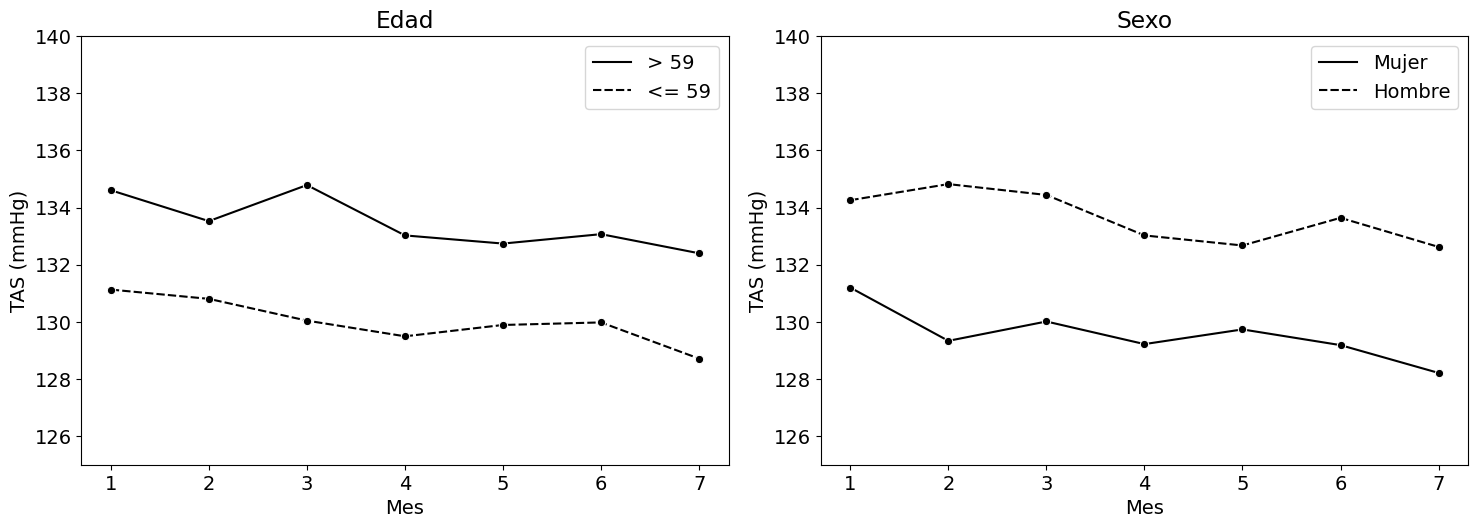

In [7]:
plt.figure(figsize=(15,10))

# Separar grupos por covariable
edad_mediana = int(
    df_basal
    .drop_duplicates(["idPaciente", "Edad"])["Edad"]
    .median()
)
hue_edad = df["Edad"] > edad_mediana
hue_edad = hue_edad.map(
    {
        True: f"> {edad_mediana}",
        False: f"<= {edad_mediana}"
    }
)
hue_sexo = df["Sexo"].map({0: "Mujer", 1: "Hombre"})

hues = {
    "Edad": hue_edad,
    "Sexo": hue_sexo
}

covs = ["Edad", "Sexo"]
for i, cov_name in enumerate(covs):
    axs = plt.subplot(int(len(covs)/2)+1,2,i+1)
    line = sns.lineplot(
        x=df["Mes"],
        y=df["TAS"],
        marker="o",
        hue=hues[cov_name],
        style=hues[cov_name],
        palette=["black", "black"],
        ci=None
    )
    plt.legend()
    plt.ylim(YLIM)
    plt.ylabel("TAS (mmHg)")
    plt.title(cov_name)

plt.tight_layout()
plt.savefig(
    f"{PATH_TO_IMG}/TAS_vs_tpo_with_covs.png",
    bbox_inches='tight'
)
plt.show()

### Análisis de Adherencia

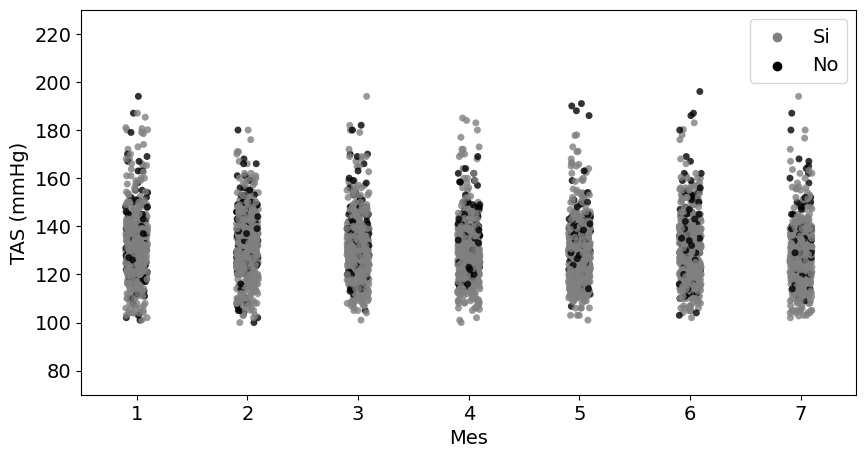

In [8]:
sns.stripplot(
    x=df["Mes"],
    y=df["TAS"],
    marker="o",
    hue=df["Adherencia"].map({0: "No", 1: "Si"}),
    palette=["gray", "black"],
    alpha=0.8,
)
plt.ylabel("TAS (mmHg)")
plt.ylim((70, 230))
plt.legend(loc="upper right")
plt.savefig(
    f"{PATH_TO_IMG}/TAS_vs_tpo_with_adherencia_scatter.png",
    bbox_inches='tight'
)

C:\Users\esteb\AppData\Local\Temp\ipykernel_12888\37058962.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


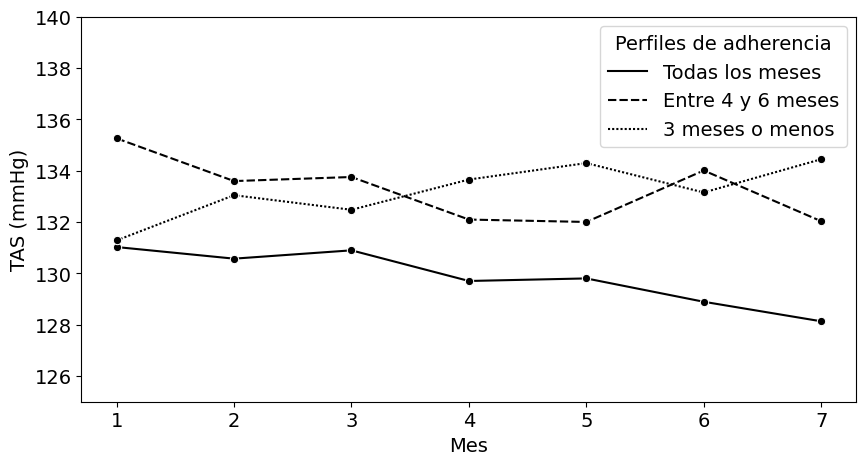

In [9]:
# Crear perfiles
aux = []
for value in df["Adherencia_Total"]:
    if value <= 3/7:
        aux.append("3 meses o menos")
    elif value == 1:
        aux.append("Todas los meses")
    else:
        aux.append("Entre 4 y 6 meses")

df["Perfiles de adherencia"] = aux

# Gráfico
plt.figure(figsize=(10,5))
sns.lineplot(
    x=df["Mes"],
    y=df["TAS"],
    marker="o",
    hue=df["Perfiles de adherencia"],
    style=df["Perfiles de adherencia"],
    palette=["black", "black", "black"],
    ci=None
)
plt.ylim(YLIM)
plt.ylabel("TAS (mmHg)")
plt.savefig(
    f"{PATH_TO_IMG}/TAS_vs_tpo_with_adherencia.png",
    bbox_inches='tight'
)

df = df.drop("Perfiles de adherencia", axis=1)

### Variograma

<Figure size 1000x500 with 0 Axes>

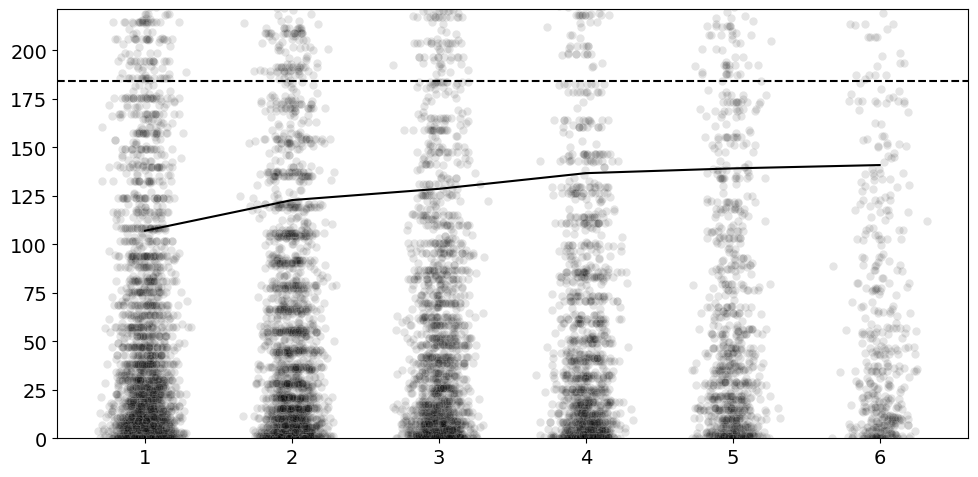

In [10]:
# Funciones auxiliares
def jitter(data, factor=0.1):
    jittered_data = data + np.random.normal(0, factor, len(data))
    return jittered_data

def variograma(id, x, y):
    """
    id = (nobs x 1) vector con los id
    y = (nobs x 1) vector respuesta (residuos)
    x = (nobs x 1) vector de covariables (tiempo)
    
    RETURN: delta.y = vec( 0.5*(y_ij - y_ik)^2 )
            delta.x = vec( abs( x_ij - x_ik ) )
    """
    uid = id.unique()
    m = len(uid)
    delta_y = []
    delta_x = []
    did = []
    for i in range(m):
        yi = y[id == uid[i]]
        xi = x[id == uid[i]]
        n = len(yi)
        expand_j = [i for i in range(n)]*n
        expand_k = np.repeat([i for i in range(n)], n)
        keep = expand_j > expand_k
        if keep.sum() <= 0:
            continue
        expand_j = [j for j, b in zip(expand_j, keep) if b]
        expand_k = [k for k, b in zip(expand_k, keep) if b]
        delta_yi = (
            0.5*(np.array(yi.iloc[expand_j])
            - np.array(yi.iloc[expand_k]))**2
        )
        delta_xi = (
            abs(np.array(xi.iloc[expand_j])
            - np.array(xi.iloc[expand_k]))
        )
        didi = np.repeat(uid[i], len(delta_yi))
        delta_y.extend(list(delta_yi))
        delta_x.extend(list(delta_xi))
        did.extend(list(didi))
    return did, delta_x, delta_y

# Agregar intercepto porque OLS lo pide
df["Intercept"] = 1

# Efectos a usar
effects = [
    "Intercept",
    "Sexo",
    "Edad",
    "Adherencia",
    "Mes",
]

# Modelo OLS
model = sm.OLS(df["TAS"], df[effects]).fit()

# Valores semivariograma
did, delta_x, delta_y = variograma(
    df["idPaciente"], df["Mes"], model.resid
)

# Spline en R
r_x = robjects.FloatVector(delta_x)
r_y = robjects.FloatVector(delta_y)
r_smooth_spline = robjects.r["smooth.spline"]
spline = r_smooth_spline( r_x, r_y, df=5 )

# Plot
plt.figure(figsize=(10,5))
var = np.var(model.resid)
fig, ax = plt.subplots(1,1)
scat = sns.scatterplot(
    x=jitter(delta_x),
    y=delta_y,
    alpha=0.1,
    color="black"
)
plt.axhline(var, color="black", linestyle="--")
scat.set(ylim=(0, 1.2*var))
plt.plot(spline[0], spline[1], color="black")
plt.tight_layout()
plt.savefig(f"{PATH_TO_IMG}/semivariogram.png", bbox_inches='tight')